In [104]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import Model, backend

### Visualization

In [105]:
parameter = 0

In [106]:
def weights(theta):
    return (1/(1+np.exp(-theta/2))-0.5)

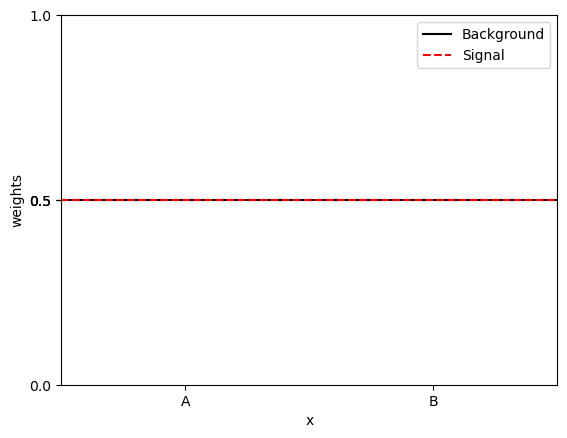

In [107]:
plt.step([0,0.5,1],[0.5,0.5,0.5], linestyle='-', color='k', label='Background')
plt.step([0,0.5,1],[0.5-weights(parameter),0.5-weights(parameter),0.5+weights(parameter)], linestyle='--', color='r', label='Signal')
plt.xlabel('x')
plt.ylabel('weights')
plt.xlim(0,1)
plt.ylim(0,1)

plt.xticks([0.25,0.75],['A','B'])
plt.yticks([0,0.5-weights(parameter),0.5,0.5+weights(parameter),1])

plt.legend()

plt.show()

In [108]:
np.random.seed(42)

theta_values = np.linspace(-10,10,21)

x_arr = np.append(np.zeros(10000), np.ones(10000))
params = np.random.choice(theta_values, size=x_arr.shape) # random values from 3 to 10 #4*np.ones(x_arr.shape) 
y_arr_1 = np.zeros(x_arr.shape)
y_arr_2 = np.ones(x_arr.shape)
wt_1 = np.ones(x_arr.shape)/2
wt_2 = np.abs(x_arr - (0.5-weights(params)))

data_1 = np.array([x_arr, params, y_arr_1, wt_1]).T
data_2 = np.array([x_arr, params, y_arr_2, wt_2]).T

# Normalization of the weights
factor_1 = 1/np.sum(data_1[:,-1])
factor_2 = 1/np.sum(data_2[:,-1])

data_1 = np.append(data_1[:,:-1], (data_1[:,-1]*factor_1)[:,np.newaxis], axis=1)
data_2 = np.append(data_2[:,:-1], (data_2[:,-1]*factor_2)[:,np.newaxis], axis=1)

data = np.append(data_1, data_2, axis=0)

np.random.shuffle(data)

#x=0 => wt_sig = 0.25, x=1 => wt_sig = 0.75

In [109]:
data

array([[ 1.00000000e+00,  6.00000000e+00,  0.00000000e+00,
         5.00000000e-04],
       [ 0.00000000e+00, -8.00000000e+00,  0.00000000e+00,
         5.00000000e-04],
       [ 0.00000000e+00, -7.00000000e+00,  1.00000000e+00,
         9.46302210e-04],
       ...,
       [ 0.00000000e+00, -1.00000000e+01,  1.00000000e+00,
         9.68353347e-04],
       [ 0.00000000e+00, -5.00000000e+00,  1.00000000e+00,
         9.00925585e-04],
       [ 1.00000000e+00, -3.00000000e+00,  0.00000000e+00,
         5.00000000e-04]])

In [110]:
def swish_activation(x, b=1):
    return x*backend.sigmoid(b*x)

get_custom_objects().update({'swish_activation': Activation(swish_activation)})


class ToyClassifierPrm(Model):
    def __init__(self):
        super().__init__()

        swish = Activation(swish_activation, name='Swish')

        self.dense = Dense(100, activation=swish, input_dim=2, kernel_initializer='he_normal')
        self.dense1 = Dense(100, activation=swish, kernel_initializer='he_normal')
        self.out = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.dense1(x)
        return self.out(x)
    
class ToyClassifier(Model):
    def __init__(self):
        super().__init__()

        swish = Activation(swish_activation, name='Swish')

        self.dense = Dense(2, activation=swish, input_dim=1, kernel_initializer='he_normal')
        self.out = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense(inputs)
        return self.out(x)

In [111]:
model_prm = ToyClassifierPrm()

optimizer = Nadam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model_prm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'], weighted_metrics=['binary_accuracy'])

In [112]:
models = []

for theta in theta_values:
    th_mod = ToyClassifier()
    th_mod.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['binary_accuracy'], weighted_metrics=['binary_accuracy'])
    models.append(th_mod)

In [113]:
datas = []

for theta in theta_values:
    inds = np.where(data[:,1]==theta)
    data_theta = data[inds][:,[0,2,3]]
    datas.append(data_theta)

In [114]:
history_arr = []

for i in range(len(models)):
    history = models[i].fit(x=datas[i][:,0][:,np.newaxis], y=datas[i][:,1][:,np.newaxis], sample_weight=datas[i][:,2][:,np.newaxis], validation_split=0.3, epochs=300, verbose=0)
    history_arr.append(history)
    print(f'Model {i}: {history.history["loss"][-1]}; {history.history["val_loss"][-1]}')

Model 0: 0.00030054544913582504; 0.0003021937736775726
Model 1: 0.00023088672605808824; 0.00024590379325672984
Model 2: 0.00029103795532137156; 0.0003485878696665168
Model 3: 0.0002799276262521744; 0.0003313757188152522
Model 4: 0.00029961104155518115; 0.00028835388366132975
Model 5: 0.0002946234308183193; 0.000297650316497311
Model 6: 0.0003061718598473817; 0.0002685000072233379
Model 7: 0.000316257297527045; 0.0003185072273481637
Model 8: 0.00032265932532027364; 0.00032793881837278605
Model 9: 0.0003594531735870987; 0.0003541412588674575
Model 10: 0.0003405306488275528; 0.0003523802733980119
Model 11: 0.0003406844334676862; 0.0003478020371403545
Model 12: 0.00032918713986873627; 0.0003344873839523643
Model 13: 0.00033846337464638054; 0.0003527693042997271
Model 14: 0.00032444653334096074; 0.0003111781261395663
Model 15: 0.00025333097437396646; 0.00033518081181682646
Model 16: 0.00037398116546683013; 0.00036938543780706823
Model 17: 0.00031242071418091655; 0.0003489446244202554
Model 

In [115]:
for i in range(len(models)):
    pass#models[i].save('models/model_'+str(i)+'_state.tf', save_format='tf')

In [116]:
s_vals = []

for i in range(len(models)):
    s = models[i].predict(np.array([[0],[1]]), verbose=0)
    s_vals.append(s)

s_vals = np.array(s_vals)

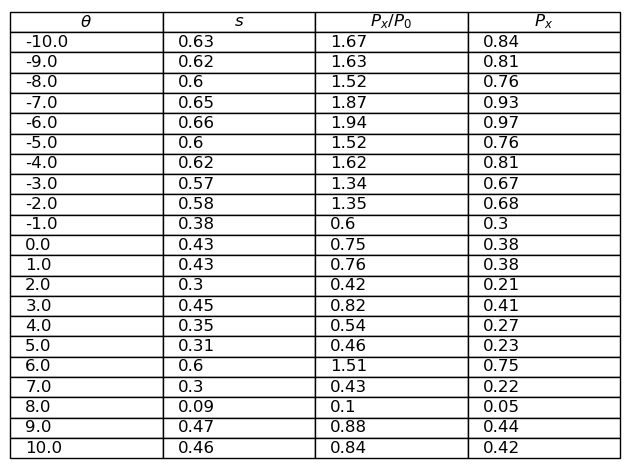

In [117]:
t_1 = theta_values
t_2 = s_vals.T[0][0]
t_3 = (s_vals/(1-s_vals)).T[0][0]
t_4 = (s_vals/(1-s_vals)*0.5).T[0][0]

fig,ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

tab = ax.table(np.round(np.array([t_1,t_2,t_3,t_4]),2).transpose(), colLabels=[u'$\\theta$',u'$s$',u'$P_x/P_0$',u'$P_x$'], cellLoc='left', loc='center')
tab.auto_set_font_size(False)
tab.set_fontsize(12)

fig.tight_layout()

plt.show()

In [118]:
model_prm.fit(x=data[:,:2], y=data[:,2][:,np.newaxis], sample_weight=data[:,3][:,np.newaxis], validation_split=0.3, epochs=300)

Epoch 1/300
88/88 [==============================] - 2s 14ms/step - loss: 3.2586e-04 - binary_accuracy: 0.5118 - weighted_binary_accuracy: 0.6335 - val_loss: 3.4439e-04 - val_binary_accuracy: 0.4842 - val_weighted_binary_accuracy: 0.5048
Epoch 2/300
81/88 [==========================>...] - ETA: 0s - loss: 3.0449e-04 - binary_accuracy: 0.4992 - weighted_binary_accuracy: 0.6559

KeyboardInterrupt: 

1/1 [==============================] - 0s 19ms/step
0.43300673 0.5643345
0.7636893757979246 1.295339031862896


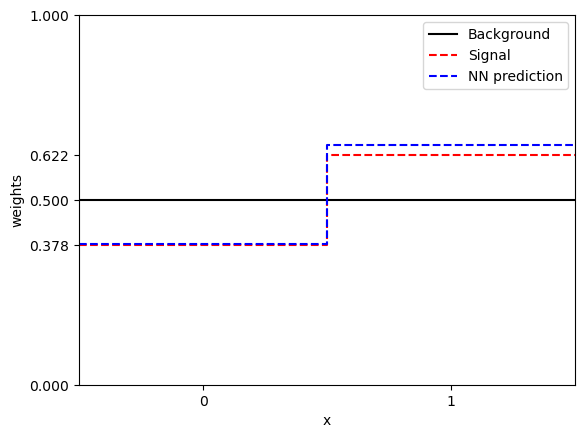

In [ ]:
#predictions = model.predict(pred_data[:,0][:,np.newaxis])
parameter = 1

pred = model_prm.predict(np.array([[0,parameter],[1,parameter]]))
p0 = pred[0,0]
p1 = pred[1,0]
print(p0, p1)
print(p0/(1-p0), p1/(1-p1))

plt.step([0,0.5,1],[0.5,0.5,0.5], linestyle='-', color='k', label='Background')
plt.step([0,0.5,1],[0.5-weights(parameter),0.5-weights(parameter),0.5+weights(parameter)], linestyle='--', color='r', label='Signal')
plt.step([0,0.5,1],[p0/(1-p0)*0.5,p0/(1-p0)*0.5,p1/(1-p1)*0.5], linestyle='--', color='b', label='NN prediction')
plt.xlabel('x')
plt.ylabel('weights')
plt.xlim(0,1)
plt.ylim(0,1)

plt.xticks([0.25,0.75],[0,1])
plt.yticks([0,0.5-weights(parameter),0.5,0.5+weights(parameter),1])

plt.legend()

plt.show()